# **Predictive Analytics: Shinkansen Passenger Satisfaction**

## Data Preprocessing

**1. Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.simplefilter("ignore")

**2. Load the training and test data separately**

In [2]:
#train data
surveydata_train = pd.read_csv("Surveydata_train.csv")
traveldata_train = pd.read_csv("Traveldata_train.csv")
#test data
surveydata_test = pd.read_csv("Surveydata_test.csv")
traveldata_test = pd.read_csv("Traveldata_test.csv")

**3. Understand the data (check for each of the following in both the train and test dataset)**
<ol>
<li>Check a sample of the data</li>
<li>Use the info() and describe() functions for more information</li>
<li>Look for the presence of null values in the dataset</li>
<li>Look for the presence of bad data or unwanted characters like "$" or "#" in the numerical columns</li>
</ol>

In [3]:
#A. Check a sample of the data
surveydata_train.sample(5)

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
60541,98860542,0,Needs Improvement,Ordinary,Needs Improvement,Poor,Convenient,Excellent,Poor,Acceptable,Excellent,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Excellent
50890,98850891,0,Needs Improvement,Green Car,Excellent,Needs Improvement,Convenient,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Needs Improvement,Needs Improvement,Good,Acceptable
85286,98885287,1,Poor,Ordinary,Poor,Poor,Inconvenient,Excellent,Excellent,Acceptable,Good,Good,Good,Good,Good,Good,Acceptable
83204,98883205,0,Needs Improvement,Green Car,Poor,Needs Improvement,Convenient,Excellent,Needs Improvement,Excellent,Excellent,Poor,Excellent,Acceptable,Poor,Acceptable,Excellent
24045,98824046,1,Excellent,Ordinary,Excellent,Excellent,Very Convenient,Needs Improvement,Excellent,Excellent,Good,Good,Good,Good,Good,Good,Acceptable


In [4]:
#A. Check a sample of the data
traveldata_train.sample(5)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
66383,98866384,Female,Loyal Customer,42.0,Personal Travel,Eco,553,18.0,7.0
10357,98810358,Male,Loyal Customer,38.0,Personal Travel,Eco,2595,0.0,0.0
93063,98893064,Female,Loyal Customer,51.0,NaN,Eco,671,1.0,0.0
61349,98861350,Female,Loyal Customer,58.0,Business Travel,Business,3830,11.0,10.0
65686,98865687,Female,Disloyal Customer,27.0,Business Travel,Business,1026,51.0,38.0


In [5]:
#B. Use the info() and describe() functions for more information
surveydata_train.info()
surveydata_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

,ID,Overall_Experience
count,9.437900e+04,94379.000000
mean,9.884719e+07,0.546658
std,2.724501e+04,0.497821
min,9.880000e+07,0.000000
25%,9.882360e+07,0.000000
50%,9.884719e+07,1.000000
75%,9.887078e+07,1.000000
max,9.889438e+07,1.000000


In [6]:
#B. Use the info() and describe() functions for more information
traveldata_train.info()
traveldata_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
count,9.437900e+04,94346.000000,94379.000000,94322.000000,94022.000000
mean,9.884719e+07,39.419647,1978.888185,14.647092,15.005222
std,2.724501e+04,15.116632,1027.961019,38.138781,38.439409
min,9.880000e+07,7.000000,50.000000,0.000000,0.000000
25%,9.882360e+07,27.000000,1359.000000,0.000000,0.000000
50%,9.884719e+07,40.000000,1923.000000,0.000000,0.000000
75%,9.887078e+07,51.000000,2538.000000,12.000000,13.000000
max,9.889438e+07,85.000000,6951.000000,1592.000000,1584.000000


In [7]:
#C. Look for the presence of null values in the dataset
surveydata_train.isnull().values.any()

True

In [8]:
#C. Look for the presence of null values in the dataset
traveldata_train.isnull().values.any()

True

In [9]:
#D. Look for the presence of bad data or unwanted characters like "$" or "#" in the numerical columns
surveydata_train.describe().columns.astype(str).str.contains("($|#)").any()

True

In [10]:
#D. Look for the presence of bad data or unwanted characters like "$" or "#" in the numerical columns
traveldata_train.describe().columns.astype(str).str.contains("($|#)").any()

True

**4. Clean the data**
<ol>
<li>Treat for missing values in both the train & test set</li>
<li>Remove bad data values in both the train & test set</li>
<li>Encode the categorical object variables in both the train & test set</li>
<li>Perform Feature Engineering if necessary</li>
<li>Scale/Normalize the dataset if necessary</li>
</ol>

In [11]:
def dataframe_cleaning(df):
    # Before cleaning any data, it is important to transform Categorical values to numerical values
    # Retrieve categorical columns, which have data type as "object"
    df_object_columns = df.select_dtypes(include=['object']).columns
    # One-hot encoding for categorical variables
    df_encoded = pd.get_dummies(df, columns=df_object_columns, dummy_na=True)
    #A. Treat for missing values in both the train & test set
    imputer = KNNImputer(n_neighbors=15)
    #np array is created
    df_imputed = imputer.fit_transform(df_encoded)
    #back to dataframe
    df_without_nans = pd.DataFrame(data=df_imputed, columns=df_encoded.columns)
    
    return df_without_nans

In [12]:
#train data
surveydata_train_clean = dataframe_cleaning(surveydata_train)
traveldata_train_clean = dataframe_cleaning(traveldata_train)
#test data
surveydata_test_clean = dataframe_cleaning(surveydata_test)
traveldata_test_clean = dataframe_cleaning(traveldata_test)

In [13]:
#if a column is not present on the test set, then it is not important in the train set. Sans the target variable "Overall_Experience"
def shape_equalizer(df1, df2):
    """train, then test"""
    df1_columns = df1.columns
    df2_columns = df2.columns
    difference = list(set(df1_columns).difference(set(df2_columns)))
    if "Overall_Experience" in difference:
        difference.pop(difference.index("Overall_Experience"))
    df1 = df1.drop(difference, axis=1)
    return df1, df2

In [14]:
#survey data
surveydata_train_equalized, surveydata_test_equalized = shape_equalizer(surveydata_train_clean, surveydata_test_clean)
#travel data
traveldata_train_equalized, traveldata_test_equalized = shape_equalizer(traveldata_train_clean, traveldata_test_clean)

In [15]:
if surveydata_train_equalized.shape[0] == traveldata_train_equalized.shape[0] and surveydata_test_equalized.shape[0] == traveldata_test_equalized.shape[0]:
    print("Same number of rows between survey and travel data sets.")

Same number of rows between survey and travel data sets.


In [16]:
# -1 due to target column "Overall_Experience"
if surveydata_train_equalized.shape[1]-1 == surveydata_test_equalized.shape[1] and traveldata_train_equalized.shape[1] == traveldata_test_equalized.shape[1]:
    print("Same number of columns between test and train data sets.")

Same number of columns between test and train data sets.


In [17]:
#last, join the two datasets for train and the two datasets for test
#train
train_data = traveldata_train_equalized.merge(surveydata_train_equalized, on='ID')
#test
test_data = traveldata_test_equalized.merge(surveydata_test_equalized, on='ID')

## Model Building

In [18]:
# train, test, split for all
X = train_data.drop('Overall_Experience', axis=1)
y = train_data['Overall_Experience']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# save function for all
def results_to_csv(y_pred, var_name):
    data = test_data.copy()
    data['Overall_Experience'] = y_pred
    result = data[['ID', 'Overall_Experience']]
    #to integers
    result[['ID', 'Overall_Experience']] = result[['ID', 'Overall_Experience']].astype(int)
    #print head
    print(result.head(5))
    #save as csv
    name = "_".join(var_name.split('_')[-2:]) + '_result.csv'
    return result.to_csv(name, index=False)

#### lightGBM Classifier

In [56]:
lgbm = make_pipeline(
    StandardScaler(),
    lgb.LGBMClassifier(objective='binary', 
                       boosting_type='gbdt', # ['gbdt': Gradient Boosting Decision Tree. 'dart', Dropouts meet Multiple Additive Regression Trees. ‘rf’, Random Forest.]
                       n_estimators=3000, 
                       learning_rate=0.02,
                       n_jobs=-1,
                       max_depth=-1)
)

lgbm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.02, n_estimators=3000,
                                objective='binary'))])

In [57]:
# Train the model
y_pred_train = lgbm.predict(X_train)

In [58]:
# Evaluate model on training data
print(confusion_matrix(y_train, y_pred_train))

[[34079   302]
 [  564 40558]]


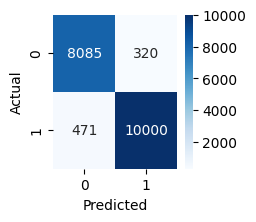

In [59]:
# Make predictions on validation data
y_pred_val = lgbm.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val)
#pretty plot
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels (depends on your problem)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [60]:
[[TN,FP],[FN,TP]] = cm
Accuracy = (TN + TP) / (TN + FP + FN + TP)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = 2 * (Precision * Recall) / (Precision + Recall)
maybe_acc = Accuracy - 0.003
target = 0.9568564
print(f"cm:\n{cm}\nAccuracy:\t{Accuracy:.7f}\nPrecision:\t{Precision:.7f}\nRecall:\t\t{Recall:.7f}\nF1_score:\t{F1_score:.7f}\n\nMaybe Acc:\t{maybe_acc:.7f}\nTarget:\t\t{target:.7f}")


cm:
[[ 8085   320]
 [  471 10000]]
Accuracy:	0.9580949
Precision:	0.9689922
Recall:		0.9550186
F1_score:	0.9619547

Maybe Acc:	0.9550949
Target:		0.9568564


In [61]:
# Make prediction
y_pred_test_lgbm = updated_lgbm.predict(test_data)
y_pred_test_lgbm

array([1., 1., 1., ..., 0., 1., 0.])

In [62]:
results_to_csv(y_pred_test_lgbm, "y_pred_test_lgbm")

         ID  Overall_Experience
0  99900001                   1
1  99900002                   1
2  99900003                   1
3  99900004                   0
4  99900005                   1


#### RandomizedSearchCV 

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Pipeline
pipeline = make_pipeline(StandardScaler(), lgb.LGBMClassifier())

# Define the parameter grid
param_grid = {
    'lgbmclassifier__n_estimators': sp_randint(500, 3000),
    'lgbmclassifier__max_depth': sp_randint(5, 50),
    'lgbmclassifier__learning_rate': sp_uniform(0.01, 0.1),
    'lgbmclassifier__num_leaves': sp_randint(20, 200),
    'lgbmclassifier__min_child_samples': sp_randint(20, 200),
    'lgbmclassifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1],
    'lgbmclassifier__subsample': sp_uniform(loc=0.2, scale=0.8), 
    'lgbmclassifier__colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
    'lgbmclassifier__reg_alpha': [0, 1e-1, 1, 2, 5],
    'lgbmclassifier__reg_lambda': [0, 1e-1, 1, 5],
}

# Set up the random search
random_search = RandomizedSearchCV(pipeline,
                                   param_grid,
                                   n_iter=100,
                                   cv=5,
                                   verbose=2, 
                                   random_state=42,
                                   n_jobs=-1,
                                   scoring='accuracy')

# Fit the random search model
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('lgbmclassifier',
                                              LGBMClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'lgbmclassifier__colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000286537B5310>,
                                        'lgbmclassifier__learning_rate': <scipy.stats._distn_infrastructure...
                                        'lgbmclassifier__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000286537ABA10>,
                                        'lgbmclassifier__reg_alpha': [0, 0.1, 1,
                                                                      2, 5],
                                        'lgbmclassifier__reg_lambda': [0, 0.1,
                                                                       1, 5],
                                        'lgbmclassifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000028653752850>},
                   random_state=42, scoring='accuracy', verbose=2)

In [33]:
# Print the best parameters and the corresponding score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'lgbmclassifier__colsample_bytree': 0.7396223262964459, 'lgbmclassifier__learning_rate': 0.0258646447642491, 'lgbmclassifier__max_depth': 26, 'lgbmclassifier__min_child_samples': 48, 'lgbmclassifier__min_child_weight': 0.001, 'lgbmclassifier__n_estimators': 1743, 'lgbmclassifier__num_leaves': 88, 'lgbmclassifier__reg_alpha': 0, 'lgbmclassifier__reg_lambda': 0.1, 'lgbmclassifier__subsample': 0.8843684672088059}
Best score: 0.957379230619787


In [43]:
random_search.best_params_

{'lgbmclassifier__colsample_bytree': 0.7396223262964459,
 'lgbmclassifier__learning_rate': 0.0258646447642491,
 'lgbmclassifier__max_depth': 26,
 'lgbmclassifier__min_child_samples': 48,
 'lgbmclassifier__min_child_weight': 0.001,
 'lgbmclassifier__n_estimators': 1743,
 'lgbmclassifier__num_leaves': 88,
 'lgbmclassifier__reg_alpha': 0,
 'lgbmclassifier__reg_lambda': 0.1,
 'lgbmclassifier__subsample': 0.8843684672088059}

#### best model

In [34]:
updated_lgbm = make_pipeline(StandardScaler(), lgb.LGBMClassifier(**random_search.best_params_))

updated_lgbm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(lgbmclassifier__colsample_bytree=0.7396223262964459,
                                lgbmclassifier__learning_rate=0.0258646447642491,
                                lgbmclassifier__max_depth=26,
                                lgbmclassifier__min_child_samples=48,
                                lgbmclassifier__min_child_weight=0.001,
                                lgbmclassifier__n_estimators=1743,
                                lgbmclassifier__num_leaves=88,
                                lgbmclassifier__reg_alpha=0,
                                lgbmclassifier__reg_lambda=0.1,
                                lgbmclassifier__subsample=0.8843684672088059))])

In [35]:
# Train the model
y_pred_train_updated = updated_lgbm.predict(X_train)

In [36]:
# Evaluate model on training data
print(confusion_matrix(y_train, y_pred_train_updated))

[[33014  1367]
 [ 1966 39156]]


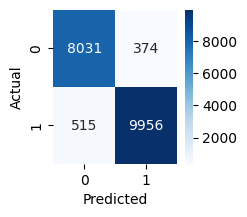

In [37]:
# Make predictions on validation data
y_pred_val_updated = updated_lgbm.predict(X_val)
cm_updated = confusion_matrix(y_val, y_pred_val_updated)

#pretty plot
plt.figure(figsize=(2,2))
sns.heatmap(cm_updated, annot=True, fmt='d', cmap='Blues')
# Add labels (depends on your problem)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [38]:
[[TN,FP],[FN,TP]] = cm_updated
Accuracy = (TN + TP) / (TN + FP + FN + TP)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = 2 * (Precision * Recall) / (Precision + Recall)
maybe_acc = Accuracy - 0.003
target = 0.9568564
print(f"cm:\n{cm_updated}\nAccuracy:\t{Accuracy:.7f}\nPrecision:\t{Precision:.7f}\nRecall:\t\t{Recall:.7f}\nF1_score:\t{F1_score:.7f}\n\nMaybe Acc:\t{maybe_acc:.7f}\nTarget:\t\t{target:.7f}")


cm:
[[8031  374]
 [ 515 9956]]
Accuracy:	0.9529032
Precision:	0.9637948
Recall:		0.9508165
F1_score:	0.9572617

Maybe Acc:	0.9499032
Target:		0.9568564


In [41]:
# Make prediction
y_pred_test_updated_lgbm = updated_lgbm.predict(test_data)
y_pred_test_updated_lgbm


array([1., 1., 1., ..., 0., 1., 0.])

In [42]:
results_to_csv(y_pred_test_updated_ada, "y_pred_test_updated_lgbm")


         ID  Overall_Experience
0  99900001                   1
1  99900002                   1
2  99900003                   1
3  99900004                   0
4  99900005                   1


#### Including normalization & pca

In [ ]:
#last, join the two datasets for train and the two datasets for test
#train
train_df = traveldata_train_equalized.merge(surveydata_train_equalized, on='ID')
#test
test_df = traveldata_test_equalized.merge(surveydata_test_equalized, on='ID')

In [ ]:
#drop target
X = train_df.drop('Overall_Experience', axis=1)
y = train_df['Overall_Experience']
ID_col = train_df['ID']

In [ ]:
scaler = StandardScaler()

# Scale objects
#train data
X_train_scaled = scaler.fit_transform(X_train)

#test data
test_scaled = scaler.fit_transform(test_df)

# Convert the result back to a dataframe
#train
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

#test
test_scaled = pd.DataFrame(test_scaled, columns=test_df.columns)

In [ ]:
# Apply PCA to the features in the training data
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)

# Apply the same PCA transformation to the test data
X_test_pca = pca.transform(test_scaled)

In [ ]:
base_estimator = DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
updated_ada = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=350, learning_rate=0.0999999999)

updated_ada.fit(X_train_pca, y_train)

In [ ]:
# Train the model
y_pred_train_updated = updated_ada.predict(X_train_pca)

In [ ]:
# Evaluate model on training data
print(confusion_matrix(y_train, y_pred_train_updated))

In [ ]:
# Make prediction
y_pred_test_updated_ada = updated_ada.predict(X_test_pca)
y_pred_test_updated_ada


In [ ]:
results_to_csv(y_pred_test_updated_ada, "y_pred_test_updated_ada")